In [2]:
# Use convolutional neural networks (CNNs) with large datasets to avoid overfitting

# Train with a large dataset: Cats and dogs
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

In [3]:
# If the URL doesn't work, visit https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765
# And right click on the 'Download Manually' link to get a new URL to the dataset
# Note: This is a very large dataset and will take time to download
!wget --no-check-certificate "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" -O "/tmp/cats-and-dogs.zip"
local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))


--2024-02-13 10:13:53--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 184.27.193.110, 2600:1406:5e00:2aa::317f, 2600:1406:5e00:281::317f
Connecting to download.microsoft.com (download.microsoft.com)|184.27.193.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.67M  75.0MB/s    in 11s     

2024-02-13 10:14:05 (69.1 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824887076/824887076]

12501
12501


In [4]:
# Prepare the data:
try:
    os.mkdir('/tmp/cats-v-dogs')
    os.mkdir('/tmp/cats-v-dogs/training')
    os.mkdir('/tmp/cats-v-dogs/testing')
    os.mkdir('/tmp/cats-v-dogs/training/cats')
    os.mkdir('/tmp/cats-v-dogs/training/dogs')
    os.mkdir('/tmp/cats-v-dogs/testing/cats')
    os.mkdir('/tmp/cats-v-dogs/testing/dogs')
except OSError:
    pass

def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[:testing_length]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)


666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


In [5]:
# Checking
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

11250
11250
1250
1250


In [6]:
# Define the model as a series of convolutional layers with max pooling :

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])


In [7]:
# Train the model :

TRAINING_DIR = "/tmp/cats-v-dogs/training/"
train_datagen = ImageDataGenerator(rescale=1.0/255.)
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=100,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

VALIDATION_DIR = "/tmp/cats-v-dogs/testing/"
validation_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=100,
                                                              class_mode='binary',
                                                              target_size=(150, 150))


Found 22499 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [8]:
history = model.fit_generator(train_generator,
                              epochs=15,
                              verbose=1,
                              validation_data=validation_generator)

<ipython-input-8-e37bf563719a>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/15
225/225 [==============================] - 486s 2s/step - loss: 0.6277 - accuracy: 0.6403 - val_loss: 0.5448 - val_accuracy: 0.7432
Epoch 2/15
225/225 [==============================] - 484s 2s/step - loss: 0.5226 - accuracy: 0.7403 - val_loss: 0.4689 - val_accuracy: 0.7760
Epoch 3/15
225/225 [==============================] - 490s 2s/step - loss: 0.4665 - accuracy: 0.7794 - val_loss: 0.4346 - val_accuracy: 0.8132
Epoch 4/15
225/225 [==============================] - 488s 2s/step - loss: 0.4199 - accuracy: 0.8057 - val_loss: 0.3724 - val_accuracy: 0.8340
Epoch 5/15
225/225 [==============================] - 488s 2s/step - loss: 0.3703 - accuracy: 0.8314 - val_loss: 0.3024 - val_accuracy: 0.8780
Epoch 6/15
225/225 [==============================] - 479s 2s/step - loss: 0.3170 - accuracy: 0.8594 - val_loss: 0.2191 - val_accuracy: 0.9104
Epoch 7/15
225/225 [==============================] - 486s 2s/step - loss: 0.2586 - accuracy: 0.8907 - val_loss: 0.1487 - val_accuracy: 0.9516

<Figure size 640x480 with 0 Axes>

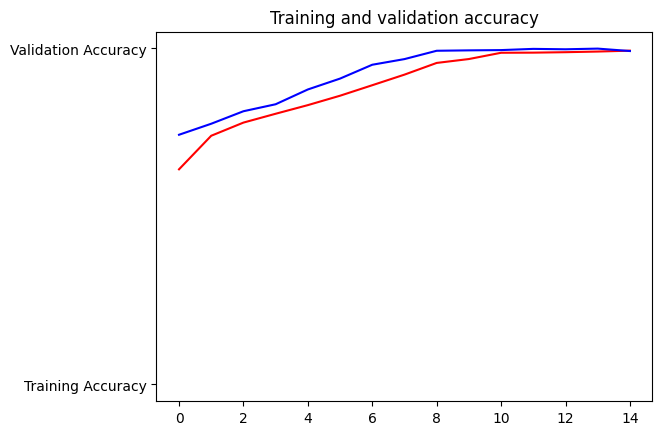

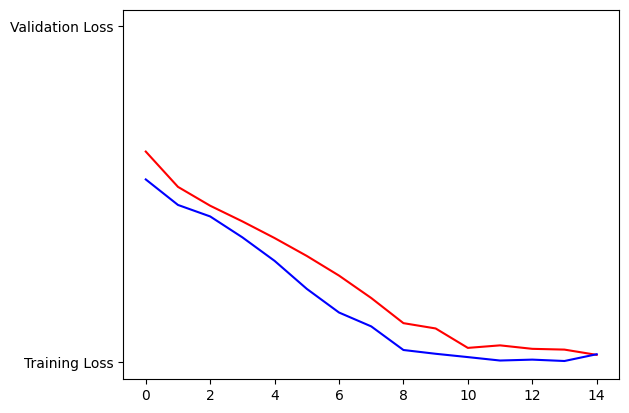

<Figure size 640x480 with 0 Axes>

In [9]:
# Explore and plot the training and validation accuracy with the following code.
# Use it to see when is reached maximum training efficiency and see whether overfitting or not.
%matplotlib inline
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.figure()

In [12]:
# Model testing:
# Here's a codeblock just for fun. You should be able to upload an image here
# and have it classified without crashing
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

Saving 45201.jpeg to 45201.jpeg
Saving 1210559_1280.jpeg to 1210559_1280.jpeg
1/1 [==============================] - 0s 29ms/step
[0.]
45201.jpeg is a cat
1/1 [==============================] - 0s 28ms/step
[1.]
1210559_1280.jpeg is a dog
